In [115]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb
from sklearn.cluster import DBSCAN
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap

IMPORT / TRAIN-TEST SPLIT

In [116]:
#original
data = pd.read_csv('DSCapstoneKaggleTrain.csv')
target = data['class']
features = data.drop('class', axis=1)
features = features.set_index('id')
X = preprocessing.StandardScaler().fit_transform(X=features)
y = target.values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [117]:
data = pd.read_csv('DSCapstoneKaggleTrain.csv')
target = data['class']
features = data.drop(['class','Unnamed: 0'], axis=1)
features = features.set_index('id')
X = preprocessing.StandardScaler().fit_transform(X=features)
y = target.values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [118]:
X_train[0][0]

0.4715497932761799

In [119]:
X_train[0][0]

0.4715497932761799

EDA

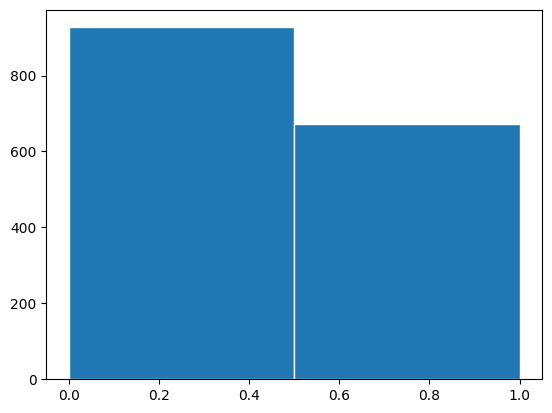

In [120]:
# print(data.head(5))
fig, ax = plt.subplots()
ax.hist(y_test, bins=2, edgecolor="white")
# A bit more 0's than 1's in the response, so stratify to be safe
plt.show()

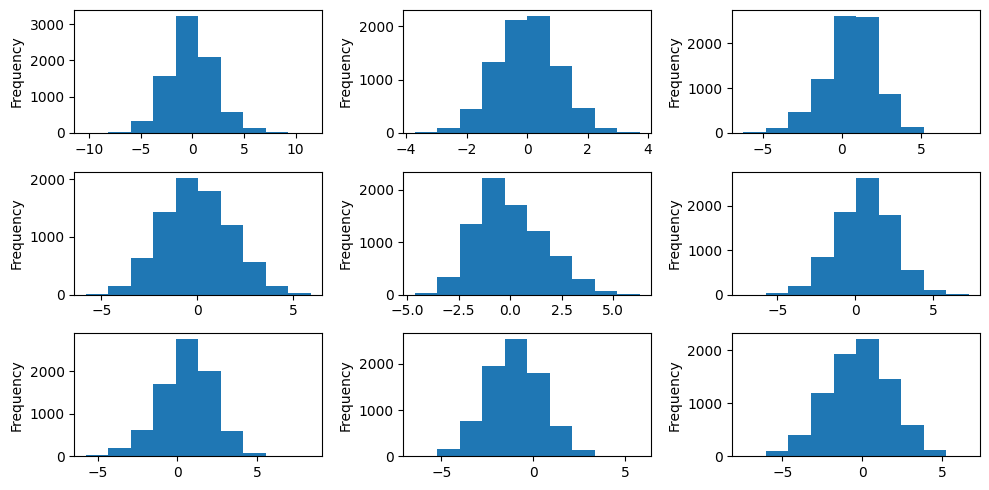

In [121]:
# All features pretty normal
figure, axes = plt.subplots(nrows=3, ncols=3, figsize =(10,5))
row = 0
col = 0

for i in range(1, 10):
    data[str(i)].plot(ax=axes[row, col], kind='hist', xlabel=str(i), rot=0, ylabel='')
    col = col+1 if col < 2 else 0
    row = row + 1 if col == 0 else row
plt.tight_layout()
plt.show()

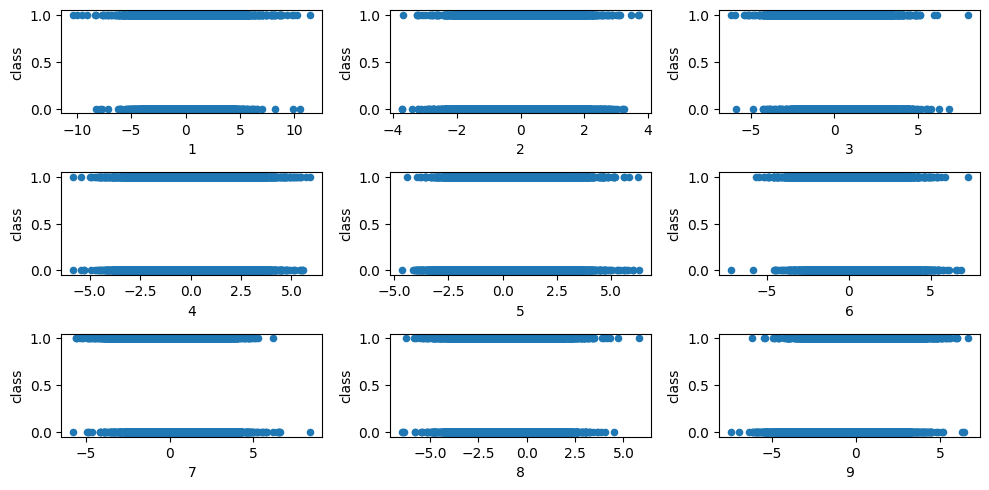

In [122]:
# No feature range favors one class or the other
#   EX: Maybe higher values for feature 2 tend to be class 1, and lower features tend to be class 0
#   This doesn't seem to be the case - MAYBE feature 9 slightly...
figure, axes = plt.subplots(nrows=3, ncols=3, figsize =(10,5))
row = 0
col = 0

for i in range(1, 10):
    data.plot(x = str(i), y = 'class', ax=axes[row, col], kind='scatter', xlabel=str(i), rot=0, ylabel='class')
    col = col+1 if col < 2 else 0
    row = row + 1 if col == 0 else row
plt.tight_layout()
plt.show()

UNSUPERVISED EDA

In [123]:
unsupervised = DBSCAN(eps=.8, metric='cityblock', min_samples=25)
clusters = unsupervised.fit(np.array(target).reshape(-1, 1))

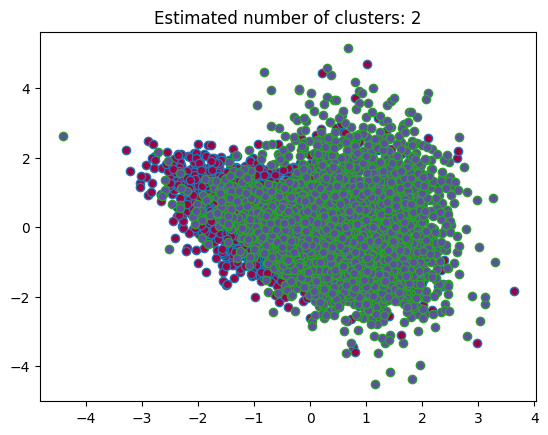

In [124]:
core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

labels = clusters.labels_

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        # markeredgecolor="r",
        markersize=6,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        # markeredgecolor="y",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

MLP

In [125]:
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(100,), random_state=1, max_iter=20000)
clf.fit(X_train, y_train)
y_pred_mlp = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
y_proba_mlp = clf.predict_proba(X_test)

print("MLP ACCURACY Train: ", accuracy_score(y_train, y_pred_train))
print("MLP ACCURACY: ", accuracy_score(y_test, y_pred_mlp))

MLP ACCURACY Train:  0.83125
MLP ACCURACY:  0.824375


XGBoost attempt

In [126]:
#Just using default parameters for now
model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=1)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

In [127]:
y_pred_xg = model.predict(X_test)
y_pred_xg_train = model.predict(X_train)
y_proba_xg = model.predict_proba(X_test)

predictions_xg_train = [round(value) for value in y_pred_xg_train]
predictions_xg = [round(value) for value in y_pred_xg]

In [128]:
accuracy = accuracy_score(y_test, y_pred_xg)
accuracy_train = accuracy_score(y_train, y_pred_xg_train)

print("Accuracy Train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy Train: 100.00%
Accuracy: 83.50%


In [129]:
# Testing on the model
dataTest = pd.read_csv('DSCapstoneKaggleTest.csv')
features = dataTest.drop(['Unnamed: 0'], axis=1)

features.set_index("id", inplace=True)
stand = preprocessing.StandardScaler().fit_transform(X=features)
predictionsTest = model.predict(stand)
pd.DataFrame(predictionsTest).to_csv('Results1HaloSight1.csv')
len(predictionsTest)



2000

In [130]:
classifier = SVC(random_state = 0, decision_function_shape='ovo', probability=True)
classifier.fit(X_train, y_train)
y_pred_svm = classifier.predict(X_test)
y_proba_svm = classifier.predict_proba(X_test)
print(accuracy_score(y_test,y_pred_svm))

0.83875


In [131]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp, normalize='true')
print("mlp:\n", cm_mlp)
cm_xg = confusion_matrix(y_test, y_pred_xg, normalize='true')
print("xg:\n", cm_xg)
cm_svm = confusion_matrix(y_test, y_pred_svm, normalize='true')
print("svm:\n",cm_svm)

mlp:
 [[0.86947141 0.13052859]
 [0.23774146 0.76225854]]
xg:
 [[0.88133765 0.11866235]
 [0.22882615 0.77117385]]
svm:
 [[0.88888889 0.11111111]
 [0.23031204 0.76968796]]


In [132]:
y_preds_ens = [0 for i in range(len(y_pred_svm))]
for i in range(len(y_preds_ens)):
    lst = [y_pred_svm[i], y_pred_xg[i], y_pred_mlp[i]]
    y_preds_ens[i] = max(lst, key=lst.count)

print(accuracy_score(y_test, y_preds_ens))

0.83875


In [133]:
# print(y_proba_mlp)
# print(y_proba_svm)
# print(y_proba_xg)

In [134]:
y_proba_ens = [0 for i in range(len(y_pred_svm))]
for i in range(len(y_proba_ens)):
    a_max = max(y_proba_mlp[i][0], y_proba_xg[i][0], y_proba_svm[i][0])
    b_max = max(y_proba_mlp[i][1], y_proba_xg[i][1], y_proba_svm[i][1])
    if b_max > a_max:
        y_proba_ens[i] = 1
        if y_test[i] != 1:
            print("%.3g" % a_max, "%.3g" % b_max, y_test[i])
    elif y_test[i] != 0:
        print("%.3g" % a_max, "%.3g" % b_max, y_test[i])


0.427 0.969 0
0.929 0.114 1
0.978 0.0802 1
0.1 0.999 0
0.945 0.134 1
0.913 0.156 1
0.489 0.847 0
0.267 0.989 0
0.642 0.784 0
0.955 0.128 1
0.455 0.763 0
0.694 0.707 0
0.423 0.884 0
0.958 0.26 1
0.262 0.963 0
0.281 0.973 0
0.229 0.995 0
0.556 0.466 1
0.6 0.46 1
0.81 0.658 1
0.508 0.551 0
0.734 0.377 1
0.801 0.738 1
0.984 0.146 1
0.442 0.853 0
0.459 0.96 0
0.282 0.955 0
0.5 0.553 0
0.964 0.128 1
0.889 0.506 1
0.911 0.604 1
0.137 0.999 0
0.104 0.977 0
0.125 0.98 0
0.675 0.476 1
0.217 0.997 0
0.234 0.996 0
0.978 0.239 1
0.134 0.999 0
0.36 0.962 0
0.776 0.659 1
0.962 0.276 1
0.16 0.999 0
0.733 0.435 1
0.991 0.131 1
0.999 0.136 1
0.909 0.495 1
0.567 0.473 1
0.875 0.15 1
0.242 0.839 0
0.784 0.529 1
0.694 0.789 0
0.482 0.538 0
0.27 0.886 0
0.995 0.146 1
0.307 0.815 0
0.244 0.891 0
0.603 0.693 0
0.747 0.848 0
0.654 0.485 1
0.867 0.419 1
0.998 0.0852 1
0.976 0.147 1
0.958 0.151 1
0.233 0.982 0
0.532 0.927 0
0.785 0.637 1
0.612 0.572 1
0.193 0.977 0
0.358 0.74 0
0.632 0.62 1
0.77 0.565 1
0.981 0.

In [135]:
print(accuracy_score(y_test, y_proba_ens))

0.8425


In [136]:
y_nprob_ens = [0 for i in range(len(y_pred_svm))]
for i in range(len(y_proba_ens)):
    a_min = min(y_proba_mlp[i][0], y_proba_xg[i][0], y_proba_svm[i][0])
    b_min = min(y_proba_mlp[i][1], y_proba_xg[i][1], y_proba_svm[i][1])
    if a_min < b_min:
        y_nprob_ens[i] = 1
        if y_test[i] != 1:
            print("%.3g" % a_min, "%.3g" % b_min, y_test[i])
    elif y_test[i] != 0:
        print("%.3g" % a_min, "%.3g" % b_min, y_test[i])


0.0307 0.573 0
0.886 0.0707 1
0.92 0.0223 1
0.00129 0.9 0
0.866 0.0551 1
0.844 0.0867 1
0.153 0.511 0
0.0105 0.733 0
0.216 0.358 0
0.872 0.0445 1
0.237 0.545 0
0.293 0.306 0
0.116 0.577 0
0.74 0.0416 1
0.0365 0.738 0
0.0268 0.719 0
0.00522 0.771 0
0.534 0.444 1
0.54 0.4 1
0.342 0.19 1
0.449 0.492 0
0.623 0.266 1
0.262 0.199 1
0.854 0.016 1
0.147 0.558 0
0.0399 0.541 0
0.0455 0.718 0
0.447 0.5 0
0.872 0.0362 1
0.494 0.111 1
0.396 0.0893 1
0.000529 0.863 0
0.0226 0.896 0
0.02 0.875 0
0.524 0.325 1
0.00266 0.783 0
0.00403 0.766 0
0.761 0.0219 1
0.00116 0.866 0
0.0379 0.64 0
0.341 0.224 1
0.724 0.0382 1
0.000655 0.84 0
0.565 0.267 1
0.869 0.00864 1
0.864 0.000996 1
0.505 0.0905 1
0.527 0.433 1
0.85 0.125 1
0.161 0.758 0
0.471 0.216 1
0.211 0.306 0
0.462 0.518 0
0.114 0.73 0
0.854 0.00515 1
0.185 0.693 0
0.109 0.756 0
0.307 0.397 0
0.152 0.253 0
0.515 0.346 1
0.581 0.133 1
0.915 0.00207 1
0.853 0.0242 1
0.849 0.0422 1
0.0183 0.767 0
0.0727 0.468 0
0.363 0.215 1
0.428 0.388 1
0.0225 0.807 0


In [137]:
print(accuracy_score(y_test, y_nprob_ens))

0.8425
